<a href="https://colab.research.google.com/github/StevenBryceLee/Counterfactual-Regret-Minimization/blob/master/module4-model-interpretation/Copy_of_LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

### Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.

###Make at least 1 partial dependence plot to explain your model.
 

In [2]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 69kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=448a0292b24164fea31e5bcf6f8ee231810ec7971791b4fbbc083cc1b6d65d13
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [16]:
!pip install category_encoders==2.*

     |████████████████████████████████| 81kB 2.2MB/s 


In [3]:
#imports and make the graphs visible
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
from pdpbox.pdp import pdp_isolate, pdp_plot

In [4]:
#Search DengAI from DrivenData to find these notebooks
import os 
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

test = pd.read_csv('features_test.csv')
trainLabels = pd.read_csv('labels_train.csv')
trainFeatures = pd.read_csv('features_train.csv')
train = pd.merge(trainFeatures,trainLabels,on=trainLabels.columns[:-1].tolist())


In [5]:
def wrangle(df):
  '''
  This function wrangles training and testing data from the DengAI datasets

  df is a pandas df with either train or test data 

  returns a cleaned df
  '''
  #Drop empty rows
  #df.drop(df[df.weekofyear==53].index,inplace=True)

  #convert datetime
  df.week_start_date = pd.to_datetime(df.week_start_date)
  #Get days, months, years
  df['years'] = df.week_start_date.apply(lambda x: x.year)
  df['months'] = df.week_start_date.apply(lambda x: x.month)
  df['days'] = df.week_start_date.apply(lambda x: x.day)

  #Drop datetime object type
  df.drop(['week_start_date',
           #'weekofyear'
           ],axis=1, inplace = True)

  # #Only applying to the training dataset, which contains labels
  if 'total_cases' in df.columns:
    df.dropna(axis=0,thresh=len(df.columns)-8,inplace=True)


  return df

train = wrangle(train)
test = wrangle(test)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from category_encoders import OneHotEncoder


In [18]:
X = train.drop('total_cases',axis=1)
y = train.total_cases
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.25,random_state=42)

In [48]:
#Actually make the model
pipe = Pipeline([
                ('encode',OneHotEncoder()),
                ('impute', SimpleImputer()),
                ('scale',MinMaxScaler()),
                ('model',XGBRegressor(random_state=41))
                ])
pipe.fit(X_train,y_train)


[21:01:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('encode',
                 OneHotEncoder(cols=['city'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1)))...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=Non

In [21]:
X_val.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'years', 'months', 'days'],
      dtype='object')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe9c67525c0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe9c6bd40b8>})

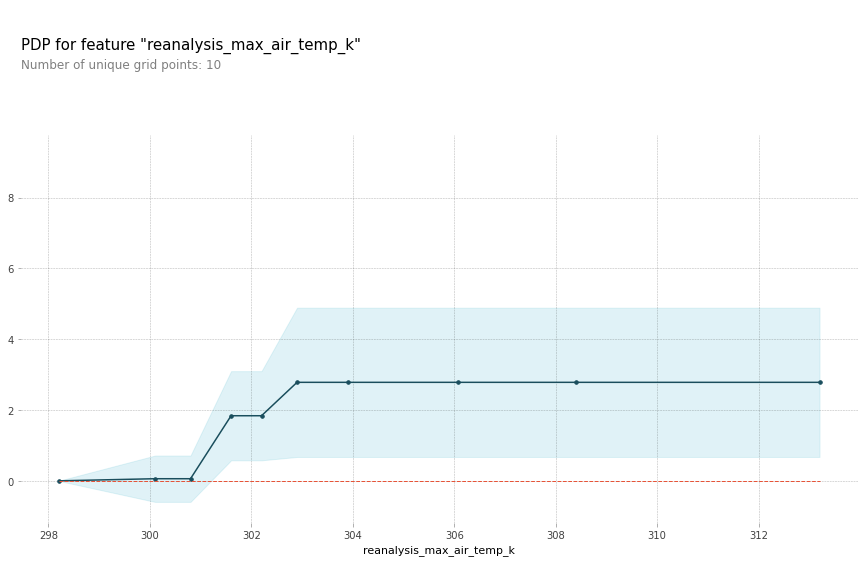

In [24]:
#Plot the model
feature = 'reanalysis_max_air_temp_k'

isolated = pdp_isolate(
    model=pipe,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature)

###Make at least 1 Shapley force plot to explain an individual prediction.

In [26]:
!pip install shap

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394132 sha256=9fb9ca7abda4ca3fc6a306b39eb939ca37017f83ec4fdcb36757fbe0366df815
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [30]:
X_train.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'years', 'months', 'days'],
      dtype='object')

In [32]:
X_train.describe().columns.tolist()

['year',
 'weekofyear',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'years',
 'months',
 'days']

In [41]:
import shap
from sklearn.ensemble import RandomForestRegressor
ohe = OneHotEncoder()
XT_train = X_train[X_train.describe().columns.tolist()].fillna(method = 'ffill').fillna(method = 'bfill')
rfr = RandomForestRegressor(random_state = 41)
rfr.fit(XT_train, y_train)

obs = X_train.iloc[[100]][X_train.describe().columns.tolist()]
obs

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,years,months,days
673,2003,15,0.12815,0.098967,0.1515,0.139543,38.52,298.33,298.407143,294.542857,301.1,296.1,43.64,79.635714,38.52,15.901429,2.7,26.4,6.171429,32.2,22.8,28.2,2003,4,9


In [42]:
rfr.predict(obs)

array([3.15])

In [43]:
#Make the plot
import shap

explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(obs)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=obs
)

###Share at least 1 visualization (of any type) on Slack!

###Make multiple PDPs with 1 feature in isolation.
 

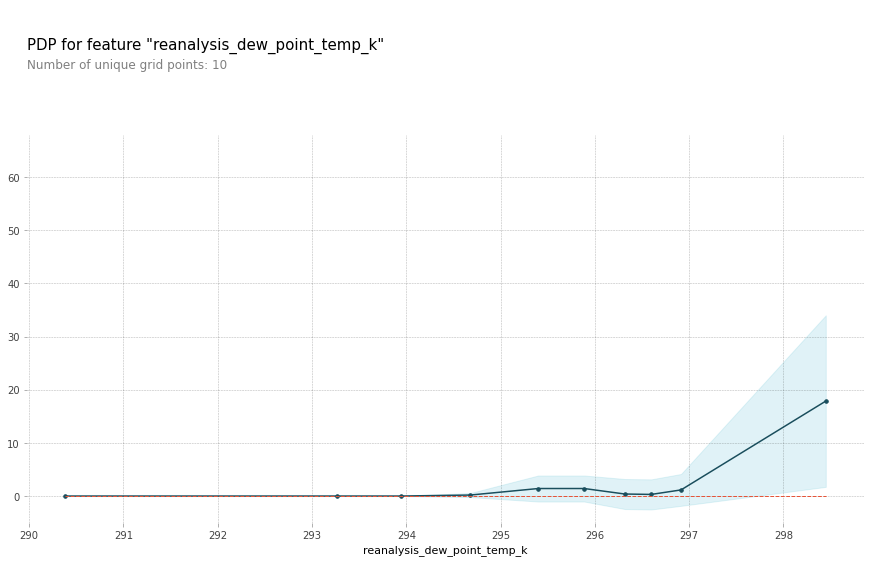

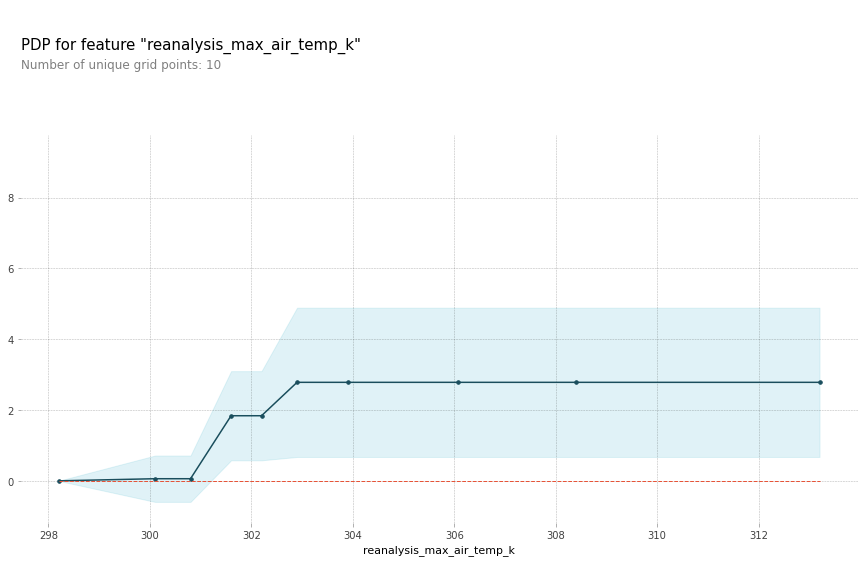

In [44]:
#Plot the model
features = ['reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k']
for feature in features:
  isolated = pdp_isolate(
      model=pipe,
      dataset=X_val,
      model_features=X_val.columns,
      feature=feature
  )

  pdp_plot(isolated, feature_name=feature)

###Make multiple PDPs with 2 features in interaction.
 

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe9b26bba58>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe9c66c94e0>})

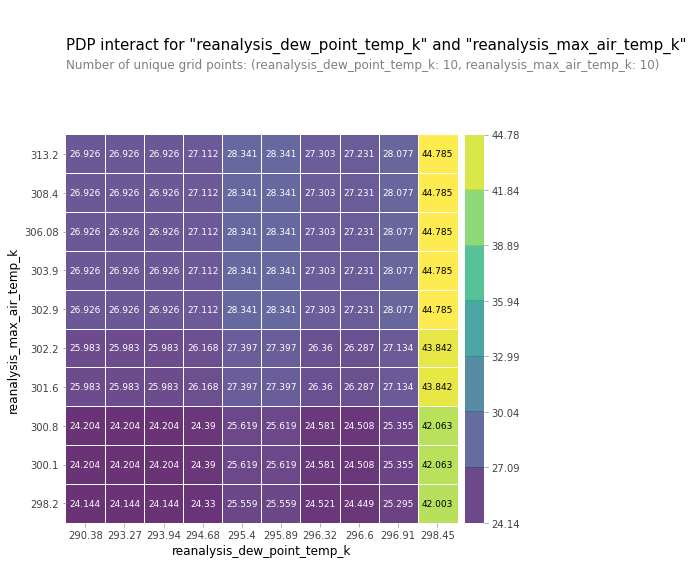

In [45]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k']

interaction = pdp_interact(
    model=pipe,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

###Use Plotly to make a 3D PDP.


[21:08:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


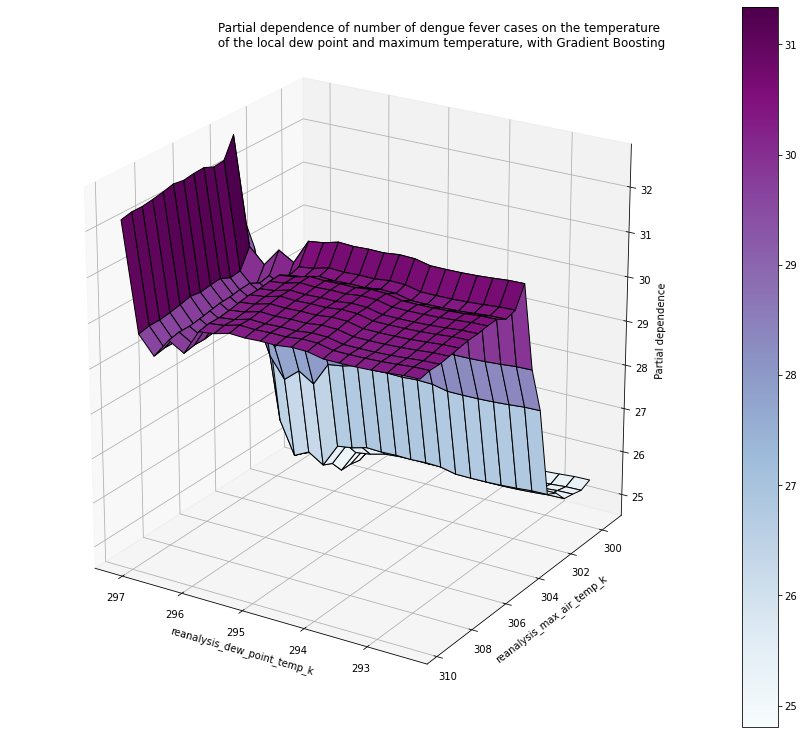

In [57]:
#I don't think plotly supports 3d PDPs natively anymore
from sklearn.inspection import partial_dependence
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,10))
features = ['reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k']
pipe.fit(X_train,y_train)
pdp, axes = partial_dependence(rfr, XT_train, features=features,
                               grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of number of dengue fever cases on the temperature\n of the local dew point'
             ' and maximum temperature, with Gradient Boosting')
plt.subplots_adjust(top=0.9)

plt.show()


### Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.
 

In [58]:
X_train.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'years', 'months', 'days'],
      dtype='object')

In [59]:
cate_train= X_train.drop(X_train.describe().columns, axis = 1).bfill().ffill()
cate_train.head()

,city
628,sj
1395,iq
1376,iq
298,sj
482,sj


In [69]:
citydict = {'sj':1,'iq':0}
reverseCityDict = {1:'sj',0:'iq'}

X_train['city_T'] = X_train.city.map(citydict)
X_val['city_T'] = X_val.city.map(citydict)

In [66]:
pipe.fit(X_train,y_train)

[21:16:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('encode',
                 OneHotEncoder(cols=['city'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1)))...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=Non

In [71]:
X_val.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'years', 'months', 'days',
       'city_T'],
      dtype='object')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe9ae3bdb70>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe9ae62db00>})

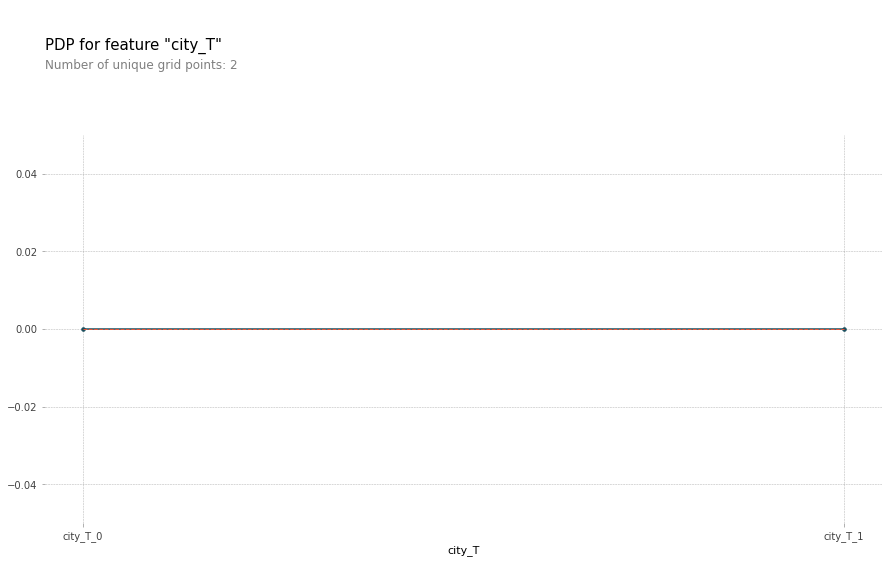

In [73]:
feature = 'city_T'

isolated = pdp_isolate(
    model=pipe,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature,
    cust_grid_points = ['sj','iq']
)

pdp_plot(isolated, feature_name=feature)
#plt.xlim(0, 100_000)

###Make Shapley force plots to explain at least 4 individual predictions.


In [84]:
observations = XT_train.iloc[7:12,:]
for count in range(len(observations)):
  print(observations.iloc[count,:])

0
year                                     1995.000000
weekofyear                                 45.000000
ndvi_ne                                     0.017400
ndvi_nw                                     0.029050
ndvi_se                                     0.208914
ndvi_sw                                     0.235486
precipitation_amt_mm                        0.000000
reanalysis_air_temp_k                     299.097143
reanalysis_avg_temp_k                     299.285714
reanalysis_dew_point_temp_k               295.220000
reanalysis_max_air_temp_k                 301.100000
reanalysis_min_air_temp_k                 297.500000
reanalysis_precip_amt_kg_per_m2            32.400000
reanalysis_relative_humidity_percent       79.404286
reanalysis_sat_precip_amt_mm                0.000000
reanalysis_specific_humidity_g_per_kg      16.604286
reanalysis_tdtr_k                           1.914286
station_avg_temp_c                         27.228571
station_diur_temp_rng_c                     

In [86]:

#for count in range(len(observations)):
obs = observations.iloc[0,:]
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(obs)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=obs
)

In [87]:
obs = observations.iloc[1,:]
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(obs)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=obs
)

In [88]:
obs = observations.iloc[2,:]
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(obs)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=obs
)

In [89]:
obs = observations.iloc[3,:]
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(obs)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=obs
)

###Use Shapley values to display verbal explanations of individual predictions.

In [91]:
#Demonstrated above. Week of year exhibits upward pressure in the winter, and downward pressure in the summer

###Use the SHAP library for other visualization types.

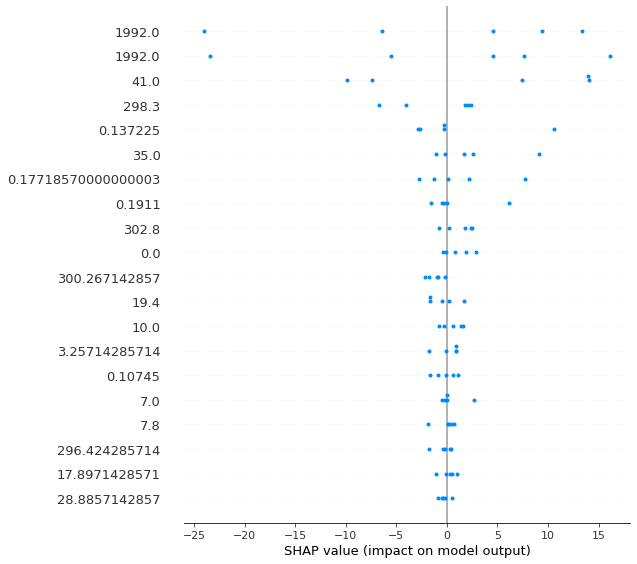

In [99]:
obs = observations.iloc[3,:]
shap_values = explainer.shap_values(observations)
shap.summary_plot(shap_values=shap_values,features=obs)